In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
46728,chr16,223472,223709,unfragmented.filtered.rvs_peak_9821,22989,593.98535,2306.10474,2298.92798,775.0,15,.,Unannotated,-,LSM11,RBP,0.0,0.0,Antisense
46729,chr16,230338,230554,unfragmented.filtered.rvs_peak_9824,19035,479.11728,1910.62622,1903.50671,691.0,12,.,Unannotated,-,NCBP2,RBP,0.0,0.0,Antisense
46727,chr10,71355030,71355103,unfragmented.filtered.rvs_peak_3379,28848,673.92236,2892.41553,2884.89331,683.0,14,.,Unannotated,-,.,Unannotated,0.0,0.0,Unannotated
46730,chr16,227336,227447,unfragmented.filtered.rvs_peak_9823,18475,477.93372,1854.53821,1847.53052,660.0,12,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
0,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5290,21237,508.77206,2130.70776,2123.70703,515.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense


/stor/home/cdw2854/cfNA/plots/peak_utils.py:500: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


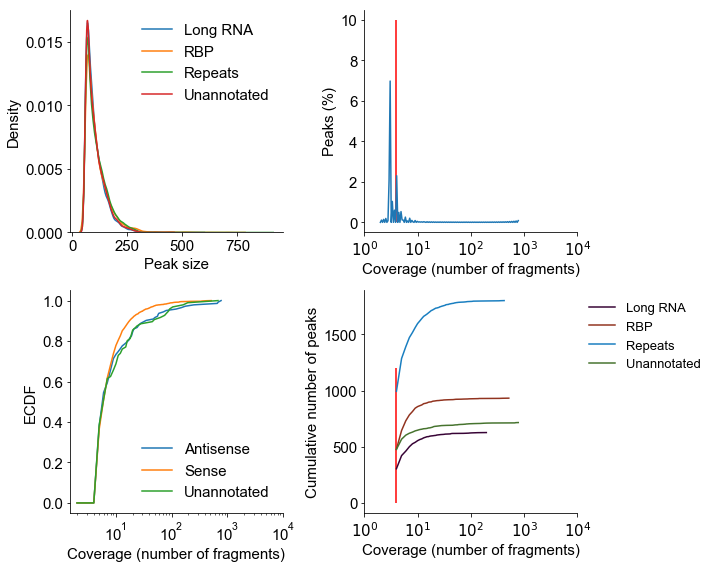

In [21]:
fig = plt.figure(figsize=(10,8))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [4]:
peak_df.sense_gtype.unique()

array(['Unannotated', 'RBP', 'Repeats', 'Long RNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


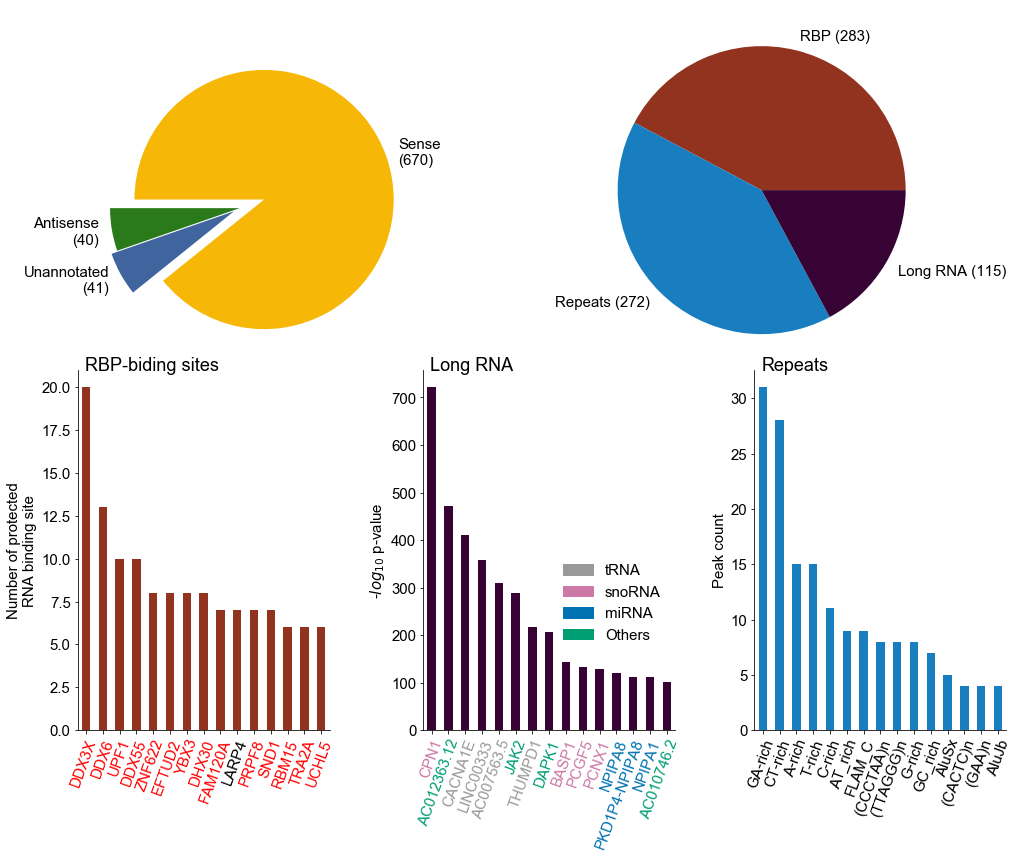

In [19]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
fig.text(-0.09,0.5, 'RBP-biding sites', fontsize=18)
fig.text(0.39,0.5, 'Long RNA', fontsize=18)
fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [10]:
import RNA 

lr_peak = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)

In [7]:
cmscan_df = read_tbl(peak_path + '/unfragmented.Long_RNA.tblout') \
    .assign(peakname = lambda d: d['query name'].str.split('(', expand=True).iloc[:,0]\
                                   .str.replace('^RF[0-9]+','')\
                                   .str.strip(' '))\
    .assign(strand = lambda d: np.where(d.strand=="+", 0,1) )\
    .groupby('peakname', as_index=False)\
    .apply(lambda d: d.pipe(lambda d1: d1[d1.strand==d1.strand.min()]).pipe(lambda d1: d1[d1.score==d1.score.max()]))
cmscan_df.head()

,,E-value,accession,bias,description of target,gc,inc,mdl,mdl from,mdl to,pass,query name,score,seq from,seq to,strand,target name,trunc,peakname
0,40,1 0.78,) -,6 0.3,-,1 0.66,8 ?,cm,m 1,1 106,o 1,unfragmented.filtered.fwd_peak_10810(+),3 14.1,6 3,3 106,1,mir-1249,+ no,unfragmented.filtered.fwd_peak_10810
1,38,6 4.2,) -,6 0.7,-,1 0.66,2 ?,cm,m 1,1 106,o 1,unfragmented.filtered.fwd_peak_10828(+),7 11.6,6 3,3 106,1,mir-1249,+ no,unfragmented.filtered.fwd_peak_10828
2,318,1.6,-,0.0,-,0.42,?,cm,1,84,1,unfragmented.filtered.fwd_peak_1163(+),17.7,15,95,0,SNORD19B,no,unfragmented.filtered.fwd_peak_1163
3,81,4 4,) -,2 0.0,-,1 0.52,4 ?,cm,m 1,1 147,o 1,unfragmented.filtered.fwd_peak_12219(+),0 10.4,7 128,8 20,1,ACAT,- no,unfragmented.filtered.fwd_peak_12219
4,317,6 3,) -,8 0.0,-,1 0.58,3 ?,cm,m 1,1 92,o 1,unfragmented.filtered.fwd_peak_13317(+),0 12.6,2 126,6 202,1,mir-263,+ no,unfragmented.filtered.fwd_peak_13317


In [ ]:
cmscan_df.reset_index().filter(regex='name')

In [ ]:
lr_peak.merge(cmscan_df, on ='peakname', how='left')\
    .filter(['chrom','start','end', 'peakname','log10p', 'sense_gname','target name','strand_x'])\
    .nlargest(15,'log10p')

In [ ]:
lr_peak.query('width == 1751')

In [ ]:
sns.distplot(peak_df.fc.transform(np.log2))
sns.distplot(peak_df.query('pileup >= 4 & sample_count >= 5').fc.transform(np.log2))

In [ ]:
lr_peak.query('peakname=="unfragmented.fwd_peak_28467"')

In [ ]:
fold = lr_peak.nlargest(20,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold.head()

# Intron #

In [ ]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

In [ ]:
intron_df \
    .query('pileup >= 5 & sample_count > 5' )\
    .filter(['chrom','start','end','peakname','sense_gname'])\
    .drop_duplicates()

In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []       

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [ ]:
','.join(rbp_df.head(15).index)

In [ ]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [ ]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

In [ ]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d